In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

2.2.3
1.26.4
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
1.6.1


In [4]:
#Loading training set into dataframe
df = pd.read_csv('./kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
#Loading testing set into dataframe
qp = pd.read_csv('./kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
qp

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [15]:
#Dropping the last columns of training set
if 'id' in df.columns:
	df = df.drop('id', axis=1) # we don't need it in this project
df.shape

(175341, 43)

In [16]:
if 'label' in df.columns:
	df = df.drop('label', axis=1) # we don't need it in this project
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal


In [20]:
#Dropping the last columns of testing set
columns_to_drop = ['id', 'label']
qp = qp.drop(columns=[col for col in columns_to_drop if col in qp.columns])
qp.shape

(82332, 43)

In [29]:
df.isnull().values.any()

False

In [30]:
qp.isnull().values.any()

False

In [31]:
#defining col list
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [32]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [33]:
#Merging train and test data
combined_data = pd.concat([df,qp])
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [34]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [35]:
tmp = combined_data.pop('attack_cat')

In [38]:
def one_hot(df, cols):
    for each in cols:  # Lặp qua từng cột trong danh sách cols
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=[each])  # Xóa cột gốc sau khi mã hóa
    
    return df


In [39]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,1,0,0,0,1,1,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,1,2,0,0,0,1,6,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,2,1,1,3,0,0,0,2,6,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,2,1,1,3,1,1,0,2,1,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,2,1,40,0,0,0,2,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,2,1,1,2,0,0,0,2,1,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,2,1,1,1,0,0,0,3,2,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,1,0,0,0,1,1,1
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,1,0,0,0,1,1,1


In [40]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [42]:
# Exclude non-numeric columns
numeric_cols = combined_data.select_dtypes(include=[np.number]).columns

# Normalizing training set
new_train_df = normalize(combined_data, numeric_cols)
new_train_df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,2.024634e-03,tcp,-,FIN,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,...,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
1,1.083170e-02,tcp,-,FIN,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,...,0.000000,0.000000,0.0,0.015625,0.00,0.00,0.0,0.000000,0.081967,0.0
2,2.705215e-02,tcp,-,FIN,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,...,0.017241,0.000000,0.0,0.031250,0.00,0.00,0.0,0.016949,0.081967,0.0
3,2.802737e-02,tcp,ftp,FIN,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,...,0.017241,0.000000,0.0,0.031250,0.25,0.25,0.0,0.016949,0.000000,0.0
4,7.490901e-03,tcp,-,FIN,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,...,0.017241,0.017241,0.0,0.609375,0.00,0.00,0.0,0.016949,0.622951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,udp,-,INT,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,...,0.017241,0.000000,0.0,0.015625,0.00,0.00,0.0,0.016949,0.000000,0.0
82328,1.843502e-02,tcp,-,FIN,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,...,0.017241,0.000000,0.0,0.000000,0.00,0.00,0.0,0.033898,0.016393,0.0
82329,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,1.0
82330,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,1.0


In [43]:
tmp

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
82327    Normal
82328    Normal
82329    Normal
82330    Normal
82331    Normal
Name: attack_cat, Length: 257673, dtype: object

In [44]:
#Appending class column to training set
new_train_df["Class"] = tmp
new_train_df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,Class
0,2.024634e-03,tcp,-,FIN,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,...,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0,Normal
1,1.083170e-02,tcp,-,FIN,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,...,0.000000,0.0,0.015625,0.00,0.00,0.0,0.000000,0.081967,0.0,Normal
2,2.705215e-02,tcp,-,FIN,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,...,0.000000,0.0,0.031250,0.00,0.00,0.0,0.016949,0.081967,0.0,Normal
3,2.802737e-02,tcp,ftp,FIN,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,...,0.000000,0.0,0.031250,0.25,0.25,0.0,0.016949,0.000000,0.0,Normal
4,7.490901e-03,tcp,-,FIN,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,...,0.017241,0.0,0.609375,0.00,0.00,0.0,0.016949,0.622951,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,udp,-,INT,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,...,0.000000,0.0,0.015625,0.00,0.00,0.0,0.016949,0.000000,0.0,Normal
82328,1.843502e-02,tcp,-,FIN,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,...,0.000000,0.0,0.000000,0.00,0.00,0.0,0.033898,0.016393,0.0,Normal
82329,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,1.0,Normal
82330,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,1.0,Normal


In [45]:
new_train_df.isnull().values.any()

False

In [46]:
y_train=new_train_df["Class"]
y_train

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
82327    Normal
82328    Normal
82329    Normal
82330    Normal
82331    Normal
Name: Class, Length: 257673, dtype: object

In [47]:
y_train.isnull().values.any()

False

In [49]:
combined_data_X = new_train_df.drop(columns=['Class'])
combined_data_X

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,2.024634e-03,tcp,-,FIN,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,...,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
1,1.083170e-02,tcp,-,FIN,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,...,0.000000,0.000000,0.0,0.015625,0.00,0.00,0.0,0.000000,0.081967,0.0
2,2.705215e-02,tcp,-,FIN,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,...,0.017241,0.000000,0.0,0.031250,0.00,0.00,0.0,0.016949,0.081967,0.0
3,2.802737e-02,tcp,ftp,FIN,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,...,0.017241,0.000000,0.0,0.031250,0.25,0.25,0.0,0.016949,0.000000,0.0
4,7.490901e-03,tcp,-,FIN,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,...,0.017241,0.017241,0.0,0.609375,0.00,0.00,0.0,0.016949,0.622951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,udp,-,INT,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,...,0.017241,0.000000,0.0,0.015625,0.00,0.00,0.0,0.016949,0.000000,0.0
82328,1.843502e-02,tcp,-,FIN,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,...,0.017241,0.000000,0.0,0.000000,0.00,0.00,0.0,0.033898,0.016393,0.0
82329,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,1.0
82330,0.000000e+00,arp,-,INT,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.000000,0.000000,1.0


In [50]:
oos_pred = []

In [51]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [52]:
kfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

6

In [56]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=64, padding="same", activation="relu", input_shape=(196, 1)))
model.add(MaxPooling1D(pool_size=(10)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape = (128, )))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))
#model.add(Reshape((128, 1), input_shape = (128, )))
model.add(Dropout(0.6))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [59]:
for layer in model.layers:
    print(layer.output.shape)

(None, 196, 64)
(None, 19, 64)
(None, 19, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 10)
(None, 10)


In [60]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 196, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,158 (805.30 KB)

 Trainable params: 206,028 (804.80 KB)

 Non-trainable params: 130 (520.00 B)

In [62]:
for train_index, test_index in kfold.split(combined_data_X, y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:", train_index)
    print("test index:", test_index)
    print(train_y.value_counts())
    
    train_X_over, train_y_over = oversample.fit_resample(train_X, train_y)
    print(train_y_over.value_counts())
    
    # Use only numeric columns for training and testing
    x_columns_train = numeric_cols
    x_train_array = train_X_over[x_columns_train].values
    x_train_1 = np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
    dummies = pd.get_dummies(train_y_over)  # Classification
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values
    
    x_columns_test = numeric_cols
    x_test_array = test_X[x_columns_test].values
    x_test_2 = np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
    dummies_test = pd.get_dummies(test_y)  # Classification
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values
    
    model.fit(x_train_1, y_train_1, validation_data=(x_test_2, y_test_2), epochs=9)
    
    pred = model.predict(x_test_2)
    pred = np.argmax(pred, axis=1)
    y_eval = np.argmax(y_test_2, axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     0      1      2 ... 257669 257670 257672]
test index: [     9     14     15 ... 257658 257668 257671]
Class
Normal            77500
Generic           49059
Exploits          37104
Fuzzers           20205
DoS               13628
Reconnaissance    11656
Analysis           2231
Backdoor           1940
Shellcode          1259
Worms               145
Name: count, dtype: int64
Class
Normal            77500
Worms             77500
Generic           49059
Exploits          37104
Fuzzers           20205
DoS               13628
Reconnaissance    11656
Analysis           2231
Backdoor           1940
Shellcode          1259
Name: count, dtype: int64
Epoch 1/9
9128/9128 ━━━━━━━━━━━━━━━━━━━━ 158s 17ms/step - accuracy: 0.7560 - loss: 0.7099 - val_accuracy: 0.7593 - val_loss: 0.5959
Epoch 2/9
9128/9128 ━━━━━━━━━━━━━━━━━━━━ 153s 17ms/step - accuracy: 0.8298 - loss: 0.4572 - val_accuracy: 0.7759 - val_loss: 0.5538
Epoch 3/9
9128/9128 ━━━━━━━━━━━━━━━━━━━━ 169s 18ms/step - accuracy: 0.8

In [63]:
oos_pred 

[0.7957667768825968,
 0.803846691193592,
 0.8141852559027616,
 0.8162766329025498,
 0.8200023285597857,
 0.8230760274770055]

In [64]:
test_y.value_counts()

Class
Normal            15500
Generic            9812
Exploits           7421
Fuzzers            4041
DoS                2725
Reconnaissance     2331
Analysis            446
Backdoor            388
Shellcode           252
Worms                29
Name: count, dtype: int64

In [65]:
dummies_test.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
      dtype='object')

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [68]:
confussion_matrix

array([[   36,     0,    26,   335,     0,     0,    49,     0,     0,
            0],
       [    0,    22,    41,   308,     2,     0,     6,     4,     5,
            0],
       [    0,    10,   410,  2193,    14,    14,    27,    31,    24,
            2],
       [    1,     5,   362,  6595,    56,    34,   178,   110,    40,
           40],
       [    0,     0,    56,   494,  2239,     3,  1179,    49,    17,
            4],
       [    0,     0,     6,   143,    10,  9634,     8,     3,     5,
            3],
       [    5,     0,     9,   132,   736,     4, 14500,    87,    23,
            4],
       [    0,     1,    71,   446,    11,     0,    43,  1752,     5,
            2],
       [    0,     0,     0,    42,    17,     5,    14,    41,   132,
            1],
       [    0,     0,     0,     2,     0,     0,     0,     0,     0,
           27]], dtype=int64)

In [69]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

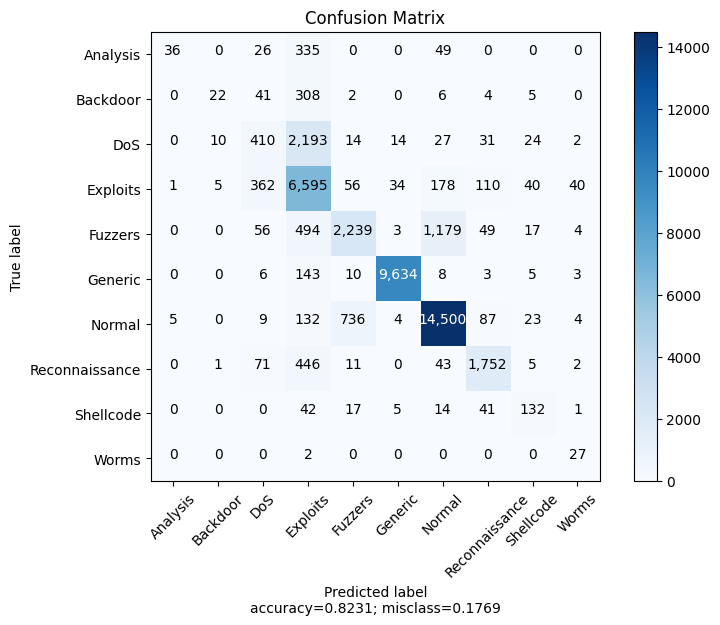

In [70]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic','Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
                      title        = "Confusion Matrix")

In [71]:
# x axis values 
x = [2,4,6,8,10] 
# corresponding y axis values 
y = [95,79,93,86,96] 

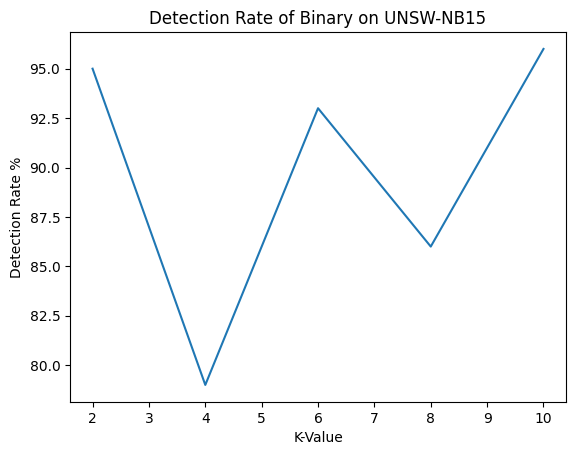

In [72]:
# plotting the points  
plt.plot(x, y) 

# naming the x axis 
plt.xlabel('K-Value') 

# naming the y axis 
plt.ylabel('Detection Rate %') 
  
# giving a title to my graph 
plt.title('Detection Rate of Binary on UNSW-NB15') 
  
# function to show the plot 
plt.show() 